# 문장 단위 Word2Vec + LDA

- Ubuntu 18.04 LTS (Mecab 때문에 윈도우에서는 안돌아갑니다!)
- 52GB RAM, 8 Cores
- 문장 토크나이징에는 꼬꼬마, 명사 추출에는 Mecab 사용

In [69]:
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt

from konlpy.tag import Mecab, Kkma
from gensim.models import Word2Vec
from gensim.test.utils import datapath

## 1.데이터 전처리

문장 단위로 모델을 훈련하기 때문에 어느 정도 유의미한 분석이 가능한 문서들만을 남겨줍니다. 기준은 30글자 이상, 5어절 이상으로 잡았습니다. 최종적으로 약 38만 건의 문서를 대상으로 모델링했습니다.

In [ ]:
# 중복 제거
data = pd.read_csv("./data/data.csv").dropna().drop_duplicates("Content") # 중복 제거

# 카테고리 정렬, 불필요한 컬럼 드랍, 한글 및 띄어쓰기만 남겨주기
hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글과 띄어쓰기를 제외한 모든 글자 삭제
data = data.assign(
    Content = data.Content.apply(lambda x: x.strip()[1:-1]).apply(lambda x: hangul.sub("", x).strip()),
    Category = data.Category.apply(lambda x: x.strip()).replace({
        "외교/통일/국토":"외교/통일/국방", "안전/환제":"안전/환경", "보건복업지":"보건복지"
    })).drop(columns = ["Unnamed: 0", "Unnamed: 0.1"]).dropna() # 간단한 전처리

# 문장 단위로 훈련할 것이므로 유의미하게 분석 가능한 수준의 문서만 남김
data = data[(data.Content.apply(len) >= 30) & (data.Content.apply(lambda x: len(x.split(" ")) >= 5))] # 30글자 5어절 이상만

# 데이터 저장
data.to_csv("data/data.csv", index=False, encoding = "utf-8")

In [2]:
data = pd.read_csv("data/data.csv", encoding= 'utf-8')

In [15]:
data.shape

(383169, 5)

## 2. 모델 훈련

문장 토크나이징에는 꼬꼬마, 명사 추출에는 메캅을 사용합니다. 인코딩 등의 문제가 가끔씩 걸리기 때문에 꼬꼬마 분석기의 `sentences` 메소드에 예외 처리 기능을 추가해줍니다.

In [2]:
class myKkma(Kkma):
     def sentences(self, phrase):
        """
        Sentence detection: 예외처리 추가
        """
        try:
            sentences = self.jki.morphAnalyzer(phrase)
            if not sentences: return []
            return [sentences.get(i).getSentence() for i in range(sentences.size())]
        except:
            return []

kkma, mecab = myKkma(), Mecab()

카테고리별로 Word2Vec 모델을 훈련하는 함수를 정의합니다.

1. 카테고리에 맞게 데이터 필터
2. 문장 단위로 구분해서 저장
3. 명사 추출
4. 모델 훈련 및 저장

In [6]:
def modelTrain(cat):
    df = data[data.Category == cat] # 카테고리 필터
    filename = cat.replace("/","")
    result = df.Content.apply(lambda x: "|".join(kkma.sentences(x))) # 문장 단위로 구분
    result.reset_index().drop("index", axis=1).to_csv(f"data/{filename}.csv", index=False) # 문장 파싱 결과 저장
    tmp = pd.read_csv(f"data/{filename}.csv").dropna()
    nouns = [mecab.nouns(sentence) for sentence in tmp.Content.apply(lambda x: x.split("|")).sum()] # 명사 추출
    model = Word2Vec(nouns, window=3, min_count=3, size=100, sg=1) # 모델 훈련
    model.save(f"models/skipgram/{filename}.model") # 모델 저장

In [ ]:
# 실제로는 7개 세션에서 나눠서 돌렸습니다
for cat in data.Category.unique():
    modelTrain(cat)

저장된 모델을 불러와서 '정의'와 가장 가까운 단어 50개를 반환하는 함수를 정의합니다.

In [3]:
def loadAndVal(path, topn=50):
    mostSimilar = Word2Vec.load(path).wv.most_similar("정의", topn=topn)
    
    result = pd.DataFrame({
        "category":path.split("/")[-1].split(".")[0],
        "rank":np.arange(1,51),
        "keyword":[word for word, distance in mostSimilar],
        "distance":[distance for word, distance in mostSimilar],
        
        
    })
    
    return result

In [ ]:
sgModels = [f"./models/skipgram/{filename}" for filename in os.listdir("./models/skipgram/")]
sgResult = pd.concat(list(pd.Series(sgModels).apply(loadAndVal)))
sgResult.pivot(index = "rank", columns = "category", values = "keyword")

In [12]:
sgResult.to_csv("정의단어/정의단어_문장단위.csv", index=False)
sgResult.pivot(index = "rank", columns = "category", values = "keyword").to_csv("정의단어/피봇테이블_문장단위.csv")

In [10]:
sgResult.pivot(index="rank", columns="category", values="keyword")

category,경제민주화,교통건축국토,기타,농산어촌,문화예술체육언론,미래,반려동물,보건복지,성장동력,안전환경,외교통일국방,육아교육,인권성평등,일자리,저출산고령화대책,정치개혁,행정
rank,,,,,,,,,,,,,,,,,
1,구현,구현,법치,평등,삽,여긴,조장,공화국,상식,구현,독선,구현,구현,평등,평화,공의,구현
2,구호,공평,구현,촛불,구현,조자,모방,초석,존중,사법부,법치주의,만인,공의,구현,민주,구현,공의
3,만인,만인,법치주의,주권,불의,권선징악,도태,공정,관행,법치,정직,출발점,실현,균등,자국민,공정,근간
4,반칙,공의,공의,약자,사제단,구현,비상식,만인,추구,기강,공정성,공의,여신상,공평,애국,정의로운,반칙
5,공의,반칙,보루,눈치,민중,공의,바탕,공평,이념,공의,자숙,기회균등,첩경,염원,후손,아량,여신상
6,승승,취임사,불의,인권,평등,법치주의,단계,입각,뿌리,저울,결집,대한,법질서,취임사,공정,사제단,공정
7,공서,심상,갈망,상식,강자,족속,세계인,개법,대립,민중,물음,승리,만인,입각,비판,여신상,배신
8,수호,애국,련지,역사,천주교,지도층,제시,부조리,이성,법치주의,공정,평등,법치국,법치,서양,갈구,공명정대
9,법치주의,입각,여신상,탄생,백계,구태,역행,법치주의,강자,수호자,공의,씨앗,법치,용단,정당,공정성,법치주의


## 3. 전체 데이터로 모델 훈련

`modelTrain` 함수에서 만들어진 카테고리별 문장 단위 데이터들을 전부 읽어와 합쳐줍니다.

In [2]:
filelist = os.listdir("./data"); filelist.remove("data.csv") # 문장 단위로 잘라놓은 데이터들
sentences = pd.concat([pd.read_csv(f"./data/{filename}") for filename in filelist]).dropna() # 읽어와서 합치기

데이터를 10000개 단위로 잘라 명사를 추출해줍니다.

In [ ]:
result = []
for i in range(38):
    start = i * 10000; end = start + 10000
    tmp = sentences.iloc[start:end].Content.apply(lambda x: x.split("|"))
    tmp = list(map(mecab.nouns,tmp.sum()))
    result.append(tmp)
    print(i)

In [24]:
nouns = np.array(result).sum()

Word2Vec 훈련

In [32]:
model = Word2Vec(nouns, window=3, min_count=3, size=100, sg=1) # 모델 훈련
model.save("./models/skipgram/total.model")

기존 결과와 병합해서 저장

In [82]:
keywords = loadAndVal("./models/skipgram/total.model")
sgResult = pd.read_csv("./정의단어/정의단어_문장단위.csv")
pd.concat([sgResult, keywords]).to_csv("./정의단어/정의단어_문장단위.csv", index=False)
pd.concat([sgResult, keywords]).pivot(index = "rank", columns = "category", values = "keyword").to_csv("./정의단어/피봇테이블_문장단위.csv")

# 4. 토픽 모델링

수진님 코드 똑같이 썼고 맨 처음 필터링 부분만 판다스로 바꿔 썼습니다.

In [5]:
from custom import * # 수진님이 만들어두신 함수들

#키워드 및 불용어 지정
KEYWORD = '정의'
stop_words = [KEYWORD, '국민', '대한민국', '한국', '정부', '대통령', '문재인', '사회', '사람', '문제', '청원', '모든', '대한', '지금', '현재', '나라', '국가', '우리', '저희', '관련', '생각', '까지', '면서', '부터', '대해', '때문', '위해', '대로', '이나', '해주', '도록', '이상', '정말', '내용', '당하', '아무', '보고', '래서', '더니', '려면', '고하', '처럼', '또한']

데이터 필터: 타겟 단어들을 포함하는 문서 대상으로

In [6]:
data = pd.read_csv("data/data.csv")
bools = data.Content.apply(lambda doc: any([x in doc for x in np.append(keywords.keyword.values, "정의")])) # 정의 + Top50 단어들을 포함하는 문서
justice = data[bools]

In [8]:
docs_nouns = [mecab.nouns(doc) for doc in justice.Content] # 포매팅(명사추출)
docs_filtered = [[term for term in doc if term not in stop_words and len(term)>1] for doc in docs_nouns] # 불용어 필터
article_indexes = [k for k in range(len(docs_filtered))]
corpus, dictionary = build_doc_word_matrix(docs_filtered)
# corpus = dtm based on frequency

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 81523
Number of documents: 95844


In [9]:
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary, corpus=corpus, texts=docs_filtered, start=2, limit=40, step=6
)  #start, limit, step 조정

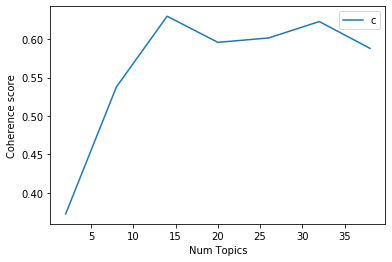

In [10]:
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
#토픽 수와 토픽 키워드 수 지정
NUM_TOPICS = 14

#모델 시행
lda_model = models.ldamodel.LdaModel(
    corpus,
    num_topics=NUM_TOPICS,
    id2word=dictionary,
    alpha='auto'
)

#실행할 때마다 결과가 달라짐; 원하는 결과가 나올 때까지

#모델링 결과 몇개만 확인해보기
for i in range(10):
    print(article_indexes[i])
    topics_list = lda_model.get_document_topics(corpus[i])
    print(docs_filtered[i])
    print(topics_list)
    hi_topic, hi_prob = get_highest_topic(topics_list)
    print(hi_topic, hi_prob)
    
    print('\n')

In [80]:
lda_model.save("./LDA/top50.lda")

## 5. LDA 결과분석

In [81]:
pyLDAvis.save_html(prepared_data, './LDA/top50LDAvis.html')

In [78]:
#주피터에서 보기
pyLDAvis.display(prepared_data)

문서별로 가장 가능성이 높은 토픽 매칭 > 데이터프레임에 결합

In [25]:
probs = pd.Series(corpus).apply(lambda x: lda_model.get_document_topics(x)) # 문서별 확률 계산
topics = probs.apply(get_highest_topic) # 가장 가능성 높은 토픽 할당
justice = pd.concat([justice.reset_index(drop=True), pd.DataFrame(list(topics), columns = ['topic', 'prob'])], axis=1) # 데이터프레임에 붙여줌

In [53]:
justice.head()

,Start_Date,Category,Vote_Count,Title,Content,topic,prob
0,2017-08-19,일자리,53,공공기관 무조건적인 정규직전환을 반대합니다.,현정부에서 정규직 일자리를 늘리는 것에 찬성합니다 그런데 공공기관 비정규직들은 인맥...,13,0.770979
1,2017-08-19,보건복지,2,보건복지부 부령 제339호중 “특수의료장비 운영에 관한 규칙” 중 불합리한 행정제...,청원인 왕 기 운 서울 도봉구 창동 삼성아파트 호 청원취지 보건복지...,6,0.494555
2,2017-08-19,외교/통일/국방,218,국가유공자등 예우및 지우너에 관한 법률 시행령 개정,지금부터 년전 년 전쟁때 조국 대한민국이 위태로운 시점에 우리들 아버님께서는 조국의...,4,0.400129
3,2017-08-19,경제민주화,2137,소액주주를 보호해주십시오,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 상장사의 소액 주주입니다 중...,9,0.544514
4,2017-08-19,기타,17,비리제보처를 만들어주세요.,현 정부에 국민들이 가장 원하는 것은 부패척결입니다 우리 사회에 각종 비리들이 많...,13,0.431348


         count        mean           std  min  25%   50%   75%        max
topic                                                                    
0      11247.0  815.149106  13297.303827  0.0  3.0  10.0  33.0   757730.0
12      9175.0  550.944414   9614.252049  0.0  3.0  10.0  27.0   419006.0
6       4147.0  425.863757   6389.176212  0.0  2.0   5.0  18.0   269180.0
5       7245.0  418.473154   6053.102870  0.0  2.0   7.0  23.0   281764.0
4       3637.0  327.279351   3358.786656  0.0  2.0   7.0  27.0   132423.0
11      8565.0  317.232808   8572.397471  0.0  2.0   8.0  29.0   714875.0
3      19504.0  308.751077  14184.306134  0.0  3.0   8.0  19.0  1831900.0
8       7935.0  285.975551   5399.257970  0.0  4.0   9.0  21.0   259864.0
7       4509.0  285.010867   5869.225443  0.0  2.0   7.0  22.0   337964.0
13      5417.0  237.302012   2503.791684  0.0  2.0   5.0  16.0    80291.0
10      1073.0  223.488350   2831.216019  0.0  2.0   9.0  25.0    73765.0
2       2581.0  188.150329    844.0511

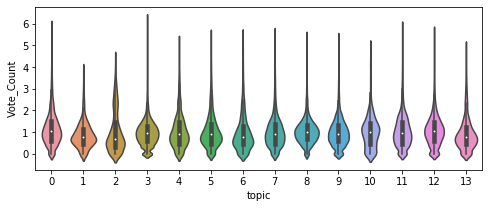

In [68]:
plt.figure(figsize = (8,3))
sns.violinplot(x=justice.topic, y=np.log10(justice.Vote_Count +1))
print(justice.groupby("topic").Vote_Count.describe().sort_values("mean", ascending=False))